# Introduction

Data:

- Direct info:
  - (DONE) rating
  - (DONE) maxRating
  - (DONE) registrationTime
  - (DONE) friendOfCount
- Extractable info:
  - \# of contest participations
  - \# of solved problems
  - average of ratings of solved problems
  - average of ratings of last m (m=50?) solved problems
  - sum of squared ratings of solved problems
  - sum of squared ratings of last `n_last_problems` solved problems
  - From last `n_featured_rated_contests` contests:
    - Performance [except from last contest]
    - Rating change [to predict from last contest]

Codeforces API useful commands:

- `contest.list`: get all contest and their info
- `contest.ratingChanges`: get the rating changes of a specific contest
- `contest.standings`: get info (solved problems, rank, etc.) about all users of a specific contest
- `user.ratedList`: get all users who have participated in at least one rated contest
- `user.rating`: get rating change history of a specified user
- `user.status`: get submissions of a specified user
- `problemset.problems`: get all problems

Algunos requerimientos para los datos:

- Solo se analizarán datos de usuarios con rating>=400, ya que la gran mayoría de usuarios con menos de 400 de rating son outliers, pues una gran cantidad de ellos dejan de competir después de un par de contests, y otros obtienen malos resultados a propósito (por los memes).
- Solo se analizarán usuarios con al menos 11 contests, ya que debemos garantizar al los al menos `n_featured_rated_contests`=5 contests, y estos no pueden coincidir con los 6 iniciales de estabilización del rating. Además los usuarios que no cumplen este requerimiento por lo general no se toman la competencia en serio y pueden constituir outliers

NOTA:
Soy anormal y tengo las columnas de submissions y ratedContests swapeadas en los 200 csv de batches guardados. Por arreglar.


## Paso 1: Preparación del Entorno y Carga de Datos

Antes de comenzar con el análisis, necesitamos asegurarnos de que todas las bibliotecas necesarias estén instaladas. Esto incluye `pandas` para la manipulación de datos, `numpy` para cálculos numéricos, `matplotlib` y `seaborn` para la visualización de datos, y `sklearn` para el aprendizaje automático.


### Installs

In [ ]:
required_libraries = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'statsmodels', 'scipy']

def install_missing_libraries(libraries):
    import subprocess
    import sys
    for library in libraries:
        try:
            __import__(library)
        except ImportError:
            print(f"La biblioteca {library} no está instalada. Instalando ahora...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", library])

install_missing_libraries(required_libraries)

La biblioteca scikit-learn no está instalada. Instalando ahora...


### Imports


In [1]:
from collections import Counter
from google.colab import drive
import requests
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

### Environment setting

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = '/content/drive/My Drive/Codeforces Statistics Project/'

## Paso 2: Análisis Exploratorio de Datos (EDA)

Antes de realizar la regresión, es útil visualizar los datos para entender mejor las relaciones entre las variables. Utilizaremos gráficos de dispersión para explorar las relaciones entre las variables independientes y la variable objetivo (lastRatingChange).


### Data fetching


In [4]:
def fetch_users_data():
    url = 'https://codeforces.com/api/user.ratedList?activeOnly=true&includeRetired=false'
    response = requests.get(url)
    data = response.json()
    return data['result']

def fetch_users_rated_contests(handle):
    url = 'https://codeforces.com/api/user.rating?handle='+handle
    response = requests.get(url)
    data = response.json()
    return data['result']

def fetch_users_submissions(handle):
    url = 'https://codeforces.com/api/user.status?handle='+handle
    response = requests.get(url)
    data = response.json()
    return data['result']

In [5]:
users_data = 0
users_data_df = 0
extended_users_data_df = 0
current_batch = 201 # -------------------------- CHANGE BEFORE RUNNING --------------------------
batch_size = 50
processed_users = {''}

def remove_processed_users():
  global users_data_df
  global processed_users
  for i in range(1, current_batch):
    if i % 10 == 0:
      print(i)
    batch = pd.read_csv(root_path+'extended_users_data_batch_'+str(i)+'.csv')
    batch_df = pd.DataFrame(batch)
    for id in batch_df.index:
      handle = batch_df.loc[id, "handle"]
      processed_users.add(handle)

  for id in users_data_df.index:
    handle = users_data_df.loc[id, "handle"]
    if handle in processed_users:
      users_data_df.drop(id, inplace = True)


def init_users_data():
  global users_data
  global users_data_df

  # users_data = fetch_users_data()
  users_data = pd.read_csv(root_path+'users_data.csv')
  users_data_df = pd.DataFrame(users_data)
  users_data_df = users_data_df.sample(frac=1)
  # remove_processed_users()


def init_extended_users_data():
  global users_data_df
  global extended_users_data_df

  columns = users_data_df.columns.tolist()
  columns.append('ratedContests')
  columns.append('submissions')

  extended_users_data_df = pd.DataFrame(columns=columns)


def init_raw_dataframes():
  init_users_data()
  init_extended_users_data()

In [ ]:
init_raw_dataframes()

In [ ]:
# users_data_df.to_csv(root_path+'users_data'+'.csv', index=False)

In [ ]:
def make_batch_backup():
  global current_batch
  global extended_users_data_df
  extended_users_data_df.to_csv(root_path+'extended_users_data_batch_'+str(current_batch)+'.csv', index=False)
  users_data_df.to_csv(root_path+'users_data'+'.csv', index=False)
  init_extended_users_data()

  print('----------BACKUP---------- BATCH:', current_batch)
  current_batch += 1


In [ ]:
def get_raw_data():
  i = 0 # number of processed rows in this run

  # Iterate over remaining users
  for id in users_data_df.index:
    i += 1
    handle = users_data_df.loc[id, "handle"]

    contests = fetch_users_rated_contests(handle)
    submissions = fetch_users_submissions(handle)

    features = []
    for feature in users_data_df.columns:
      features.append(users_data_df.loc[id, feature])

    features.append(contests)
    features.append(submissions)

    # Add this new row to the dataframe
    extended_users_data_df.loc[len(extended_users_data_df.index)] = features

    # Control output
    print(i, extended_users_data_df.shape[0])

    # Save batch when too big
    if extended_users_data_df.shape[0] % batch_size == 0:
      make_batch_backup()

    users_data_df.drop(id, inplace = True)

In [ ]:
get_raw_data()

In [ ]:
users_data_df.shape

(50142, 18)

In [ ]:
def bytes_to_megabytes(data):
  print(' (~ ', end='')
  print("%.2f" % round(data/1e6, 2), end='')
  print(' MB)')

def bytes_to_gigabytes(data):
  print(' (~ ', end='')
  print("%.2f" % round(data/1e9, 2), end='')
  print(' GB)')

In [ ]:
def batches_analisis():
  n_saved_batches = current_batch - 1
  n_processed_users = n_saved_batches * batch_size
  n_remaining_users = users_data_df.shape[0]
  n_total_users = n_processed_users + n_remaining_users

  print('Number of saved batches:', n_saved_batches)
  print('Batch size:', batch_size)
  print('Number of processed users:', n_processed_users)
  print('Number of remaining users:', n_remaining_users)
  print('Number of total users:', n_total_users)
  print('Memory used per batch:')

  total_memory_used = 0
  superbatch_df = pd.DataFrame()

  for i in range(1, n_saved_batches + 1):
    memory = os.stat(root_path+'extended_users_data_batch_'+str(i)+'.csv').st_size
    total_memory_used += int(memory)
    print('- Batch #'+str(i)+':', memory,'B', end='')
    bytes_to_megabytes(memory)

    batch = pd.read_csv(root_path+'extended_users_data_batch_'+str(i)+'.csv')
    batch_df = pd.DataFrame(batch)

    if superbatch_df.shape[0] == 0:
      superbatch_df = batch_df
    else:
      superbatch_df = pd.concat([superbatch_df, batch_df])

  superbatch_df = superbatch_df.reset_index(drop=True)

  average_memory_used_per_user = total_memory_used / n_processed_users
  expected_remaining_memory_to_use = average_memory_used_per_user * n_remaining_users
  expected_total_memory_to_use = total_memory_used + expected_remaining_memory_to_use

  print('Total memory used:', total_memory_used, 'B', end='')
  bytes_to_megabytes(total_memory_used)
  print('Average memory used per user:', average_memory_used_per_user,'B', end='')
  bytes_to_megabytes(average_memory_used_per_user)
  print('Expected remaining memory to use: ~', expected_remaining_memory_to_use,'B', end='')
  bytes_to_gigabytes(expected_remaining_memory_to_use)
  print('Expected total memory to use: ~', expected_total_memory_to_use,'B', end='')
  bytes_to_gigabytes(expected_total_memory_to_use)

  graph_ratings(superbatch_df)
  print(superbatch_df.shape)



Number of saved batches: 200
Batch size: 50
Number of processed users: 10000
Number of remaining users: 50142
Number of total users: 60142
Memory used per batch:
- Batch #1: 9414650 B (~ 9.41 MB)
- Batch #2: 12171155 B (~ 12.17 MB)
- Batch #3: 11005874 B (~ 11.01 MB)
- Batch #4: 10100963 B (~ 10.10 MB)
- Batch #5: 15362228 B (~ 15.36 MB)
- Batch #6: 20143719 B (~ 20.14 MB)
- Batch #7: 9915100 B (~ 9.92 MB)
- Batch #8: 12263540 B (~ 12.26 MB)
- Batch #9: 6356509 B (~ 6.36 MB)
- Batch #10: 13971318 B (~ 13.97 MB)
- Batch #11: 12522441 B (~ 12.52 MB)
- Batch #12: 11202602 B (~ 11.20 MB)
- Batch #13: 8475128 B (~ 8.48 MB)
- Batch #14: 9836295 B (~ 9.84 MB)
- Batch #15: 9025145 B (~ 9.03 MB)
- Batch #16: 12346880 B (~ 12.35 MB)
- Batch #17: 11660132 B (~ 11.66 MB)
- Batch #18: 10540252 B (~ 10.54 MB)
- Batch #19: 14653320 B (~ 14.65 MB)
- Batch #20: 13734996 B (~ 13.73 MB)
- Batch #21: 12086363 B (~ 12.09 MB)
- Batch #22: 12217324 B (~ 12.22 MB)
- Batch #23: 15894734 B (~ 15.89 MB)
- Batch 

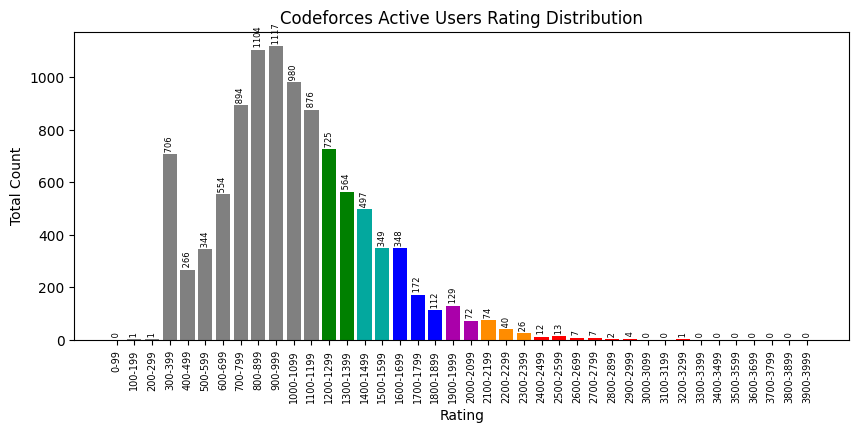

(10000, 20)


In [ ]:
batches_analisis()

### Interesting graphs


In [ ]:
color_newbie = '#808080'
color_pupil = '#008000'
color_specialist = '#03a89e'
color_expert = '#0000ff'
color_candidate_master = '#a0a'
color_master = '#ff8c00'
color_international_master = '#ff8c00'
color_grandmaster = '#ff0000'
color_international_grandmaster = '#ff0000'
color_legendary_grandmaster = '#ff0000'

rating_colors_hex = {
    0: color_newbie,
    100: color_newbie,
    200: color_newbie,
    300: color_newbie,
    400: color_newbie,
    500: color_newbie,
    600: color_newbie,
    700: color_newbie,
    800: color_newbie,
    900: color_newbie,
    1000: color_newbie,
    1100: color_newbie,
    1200: color_pupil,
    1300: color_pupil,
    1400: color_specialist,
    1500: color_specialist,
    1600: color_expert,
    1700: color_expert,
    1800: color_expert,
    1900: color_candidate_master,
    2000: color_candidate_master,
    2100: color_master,
    2200: color_master,
    2300: color_international_master,
    2400: color_grandmaster,
    2500: color_grandmaster,
    2600: color_international_grandmaster,
    2700: color_international_grandmaster,
    2800: color_international_grandmaster,
    2900: color_legendary_grandmaster,
    3000: color_legendary_grandmaster,
    3100: color_legendary_grandmaster,
    3200: color_legendary_grandmaster,
    3300: color_legendary_grandmaster,
    3400: color_legendary_grandmaster,
    3500: color_legendary_grandmaster,
    3600: color_legendary_grandmaster,
    3700: color_legendary_grandmaster,
    3800: color_legendary_grandmaster,
    3900: color_legendary_grandmaster,
}

def graph_ratings(df):
    users_count = 0
    ratings = [i for i in range(0, 4001)]  # Create a list of all possible ratings from 0 to 4000
    rating_counts = Counter(ratings)        # Initialize counts for all ratings to one
    for id in df.index:
        rating = df.loc[id, "rating"]
        rating_counts[rating] += 1

    # Define rating ranges
    ranges = [(i, i + 99) for i in range(0, 4000, 100)]
    # Define handle colors

    # Create bar graph
    plt.figure(figsize=(10, 4))  # Width: 10 inches, Height: 6 inches
    for i, (start, end) in enumerate(ranges):
        total_count = sum(rating_counts[r] for r in range(start, end+1)) - (end - start + 1)
        color = mcolors.hex2color(rating_colors_hex.get(start, '#808080'))
        bar = plt.bar(i, total_count, color=color)

        # Add count number over each bar
        plt.text(bar[0].get_x() + bar[0].get_width() / 2.0, bar[0].get_height(), " " + str(total_count),
                ha='center', va='bottom', rotation=90, fontsize=6)

    plt.xticks(range(len(ranges)), ['{}-{}'.format(start, end) for start, end in ranges], rotation=90, fontsize=7)
    plt.xlabel('Rating')
    plt.ylabel('Total Count')
    plt.title('Codeforces Active Users Rating Distribution')
    plt.show()

In [ ]:
def scattered(df, x, y, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    sns.scatterplot(x=x, y=y, data=df)
    plt.title(x+' vs '+y)
    plt.show()

def scattered_graphs(df):
    scattered(df, 'rating', 'maxRating')
    scattered(df, 'rating', 'nSolvedProblems')
    scattered(df, 'rating', 'nContestParticipations')
    scattered(df, 'rating', 'averageSolvedProblemRating')
    scattered(df, 'rating', 'averageLastSolvedProblemRating')
    scattered(df, 'rating', 'solvedProblemsRatingsPonderedSum')
    scattered(df, 'rating', 'solvedProblemsRatingsPonderedSum')
    scattered(df, 'ratingChangeLatestContest', 'rating')
    scattered(df, 'ratingChangeLatestContest', 'nSolvedProblems')
    scattered(df, 'ratingChangeLatestContest', 'nContestParticipations')
    scattered(df, 'ratingChangeLatestContest', 'averageSolvedProblemRating')
    scattered(df, 'ratingChangeLatestContest', 'averageLastSolvedProblemRating')
    scattered(df, 'ratingChangeLatestContest', 'solvedProblemsRatingsPonderedSum')
    scattered(df, 'ratingChangeLatestContest', 'solvedProblemsRatingsPonderedSum')

In [ ]:
def graph_correlation_matrix(df):
    correlation_matrix = df.corr()
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()

In [ ]:
def visualize_data(df):
    graph_ratings(df)
    scattered_graphs(df)
    graph_correlation_matrix(df)

### Extract features


In [ ]:
def get_empty_processed_users_data_df():
  df = pd.DataFrame()
  df = pd.DataFrame()

  df.insert(df.shape[1], "handle", [], True)
  df.insert(df.shape[1], "rating", [], True)
  df.insert(df.shape[1], "maxRating", [], True)
  df.insert(df.shape[1], "registrationTimeSeconds", [], True)
  df.insert(df.shape[1], "friendOfCount", [], True)
  df.insert(df.shape[1], "nSolvedProblems", [], True)

  return df

In [ ]:
processed_users_data_df = pd.DataFrame()

def init_processed_users_data():
  global processed_users_data_df
  processed_users_data_df = get_empty_processed_users_data_df()

  '''
  processed_users_data_df.insert(df.shape[1], "nContestParticipations", [], True)
  processed_users_data_df.insert(df.shape[1], "averageSolvedProblemRating", [], True)
  processed_users_data_df.insert(df.shape[1], "averageLastSolvedProblemRating", [], True)
  processed_users_data_df.insert(df.shape[1], "solvedProblemsRatingsPonderedSum", [], True)
  processed_users_data_df.insert(df.shape[1], "lastSolvedProblemsRatingsPonderedSum", [], True)


  variable_name_suffix = ['LatestContest', '2ndLatestContest', '3rdLatestContest', '4thLatestContest', '5thLatestContest']
  for i in reversed(range(0, n_featured_rated_contests)):
    if i!=0:
      df.insert(df.shape[1], "performance"+variable_name_suffix[i], [], True)
    df.insert(df.shape[1], "ratingChange"+variable_name_suffix[i], [], True)
  '''

In [ ]:
init_processed_users_data()

In [ ]:
# Requirements constants
n_featured_rated_contests = 5
n_stabilizing_contests = 6
min_rated_contests = n_stabilizing_contests + n_featured_rated_contests
min_rating = 400
n_last_problems = 50

In [ ]:
n_processed_batches = 0
n_valid_users = 0
n_discarded_users = 0

In [ ]:
# Extract users that fulfill the requirements and their features
def get_relevant_data():
  global n_processed_batches
  global n_valid_users
  global n_discarded_users
  global processed_users_data_df

  # Iterate over remaining users
  for i in range(n_processed_batches + 1, current_batch):
    batch = pd.read_csv(root_path+'extended_users_data_batch_'+str(i)+'.csv')
    batch_df = pd.DataFrame(batch)

    # print('Batch #'+str(i)+':')
    j = 0

    df = get_empty_processed_users_data_df()
    n_batch_valid_users = 0
    n_batch_discarded_users = 0

    for id in batch_df.index:
      j += 1
      rating = batch_df.loc[id, "rating"]
      handle = batch_df.loc[id, "handle"]

      # Discard low rated users
      if rating < min_rating:
        # print('-', j, "DISCARDED R")
        # print(j, handle, "DISCARDED | Rating", rating, "less than min required", min_rating)
        n_batch_discarded_users += 1
        continue

      # Rated contests data
      rated_contests_str = batch_df.loc[id, 'submissions'] # REMEMBER ratedContests and submissions columns are swaped in the dataset
      rated_contests = list(eval(rated_contests_str))

      # Discard non-stabilized users (few contest participations)
      n_rated_contests = len(rated_contests)
      if n_rated_contests < min_rated_contests:
        # print('-', j, "DISCARDED C")
        # print(j, handle, "DISCARDED | Number of contests", n_rated_contests, "less than min required", min_rated_contests)
        n_batch_discarded_users += 1
        continue

      # Submissions data
      submissions_str = batch_df.loc[id, 'ratedContests'] # REMEMBER ratedContests and submissions columns are swaped in the dataset
      submissions = list(eval(submissions_str))

      # Problems-related features
      nSolvedProblems = 0

      set_of_solved = {""}

      # Iterate over all current user's submissions
      for submission in submissions:
        # Discard non-AC
        if 'verdict' in submission:
          if submission['verdict'] != 'OK':
            continue
        else:
          continue

        # Get contest ID of current problem
        contest_id = 0
        if 'contestId' in submission:
          contest_id = submission['contestId']
        elif 'contestId' in submission['problem']:
          contest_id = submission['problem']['contestId']

        # Get current problem's ID
        problem_id = str(contest_id) +'_'+ submission['problem']['index']

        # Discard if seen before, otherwise include in the set of solveds
        if problem_id in set_of_solved:
          continue
        set_of_solved.add(problem_id)

        # If the problem has an assigned rating/difficulty
        if 'rating' in submission['problem']:
          nSolvedProblems += 1
          '''pRating = submission['problem']['rating']
          averageSolvedProblemRating += pRating
          solvedProblemsRatingsPonderedSum += pRating * pRating
          if nSolvedProblems <= n_last_problems:
            averageLastSolvedProblemRating += pRating
            lastSolvedProblemsRatingsPonderedSum += pRating * pRating
          '''

      maxRating = batch_df.loc[id, 'maxRating']
      registrationTimeSeconds = batch_df.loc[id, "registrationTimeSeconds"]
      friendOfCount = batch_df.loc[id, "friendOfCount"]

      features = [handle, rating, maxRating, registrationTimeSeconds, friendOfCount, nSolvedProblems]
      df.loc[len(df.index)] = features
      n_batch_valid_users += 1

      # Control output
      # print('-', j, handle, "ACCEPTED")

    processed_users_data_df = pd.concat([processed_users_data_df,df])
    n_valid_users += n_batch_valid_users
    n_discarded_users += n_batch_discarded_users

    print('Batch #'+str(i)+' DONE. Valid:', n_batch_valid_users, 'Discarded:', n_batch_discarded_users)
    n_processed_batches += 1

In [ ]:
get_relevant_data()

Batch #1 DONE. Valid: 19 Discarded: 31
Batch #2 DONE. Valid: 27 Discarded: 23
Batch #3 DONE. Valid: 23 Discarded: 27
Batch #4 DONE. Valid: 20 Discarded: 30
Batch #5 DONE. Valid: 29 Discarded: 21
Batch #6 DONE. Valid: 24 Discarded: 26


KeyboardInterrupt: 

In [ ]:
processed_users_data_df = processed_users_data_df.reset_index(drop=True)
print('Number of batches processed:', n_processed_batches)
print('Number of valid users processed:', n_valid_users)
print('Number of unvalid users discarded:', n_discarded_users)
processed_users_data_df

Number of batches processed: 6
Number of valid users processed: 142
Number of unvalid users discarded: 158


,handle,rating,maxRating,registrationTimeSeconds,friendOfCount,nSolvedProblems
0,itsadityasharma7124,1132,1236,1654157819,6,107
1,0d1n,1617,1617,1422182979,1,284
2,alphacoder25,1572,1572,1650713963,25,183
3,Mahim17,1028,1090,1683377249,19,412
4,MEUE,1197,1197,1641579208,51,781
...,...,...,...,...,...,...
137,tfg,2442,2841,1473248276,2166,2686
138,1.6,1273,1349,1696617770,27,239
139,lucifer_arsh1,1340,1421,1627583554,19,147
140,red222,829,1372,1522018430,6,82


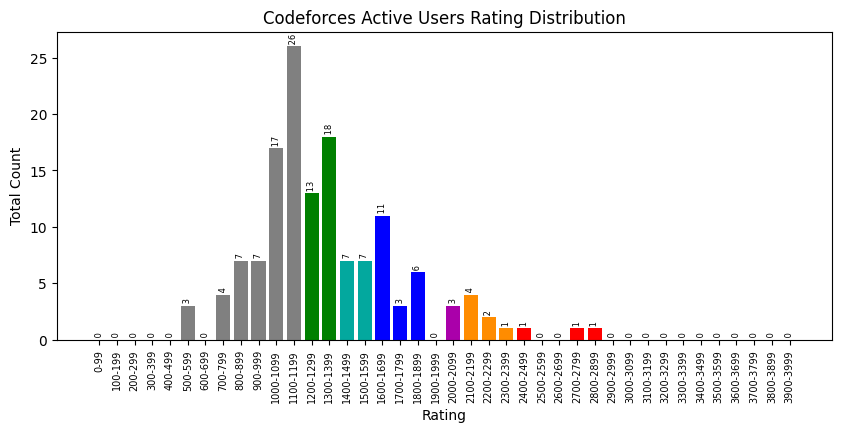

In [ ]:
graph_ratings(processed_users_data_df)

In [ ]:
processed_users_data_df.to_csv(root_path+'processed_users_data'+'.csv', index=False)

## Paso 3: Correlación entre Variables

Calcular la matriz de correlación para entender mejor las relaciones entre las variables. Esto nos ayudará a identificar qué variables independientes podrían tener una relación significativa con la variable objetivo (MEDV).


In [ ]:
visualize_data()

## Paso 4: Regresión Lineal

Utilizaremos `sklearn` y `statsmodel` para realizar la regresión lineal. Dividiremos los datos en conjuntos de entrenamiento y prueba, ajustaremos el modelo de regresión y evaluaremos su rendimiento.


In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = df[['rating','maxRating','registrationTimeSeconds','friendOfCount','nSolvedProblems','nContestParticipations','averageSolvedProblemRating','averageLastSolvedProblemRating','solvedProblemsRatingsPonderedSum','lastSolvedProblemsRatingsPonderedSum','performance5thLatestContest','ratingChange5thLatestContest','performance4thLatestContest','ratingChange4thLatestContest','performance3rdLatestContest','ratingChange3rdLatestContest','performance2ndLatestContest','ratingChange2ndLatestContest']]
y = df['ratingChangeLatestContest']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train).fit()
print(model.summary())

y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio: {mse}")
print(f"Coeficiente de Determinación R^2: {r2}")

## Paso 5: Análisis de los Residuos

Analizaremos los residuos para verificar los supuestos del modelo. Esto nos ayudará a entender si nuestro modelo es adecuado para los datos.


In [ ]:
residuos = model.resid

In [ ]:
media_residuos = np.mean(residuos)
suma_residuos = np.sum(residuos)

print(f"Media de los residuos: {media_residuos}")

if np.isclose(media_residuos, 0):
    print("La media de los residuos es cero.")
else:
    print("La media de los residuos no es cero.")

print(f"Suma de los residuos: {suma_residuos}")

if np.isclose(suma_residuos, 0):
    print("La suma de los residuos es cero.")
else:
    print("La suma de los residuos no es cero.")


In [ ]:
from scipy.stats import kstest

# Gráfico QQ de los residuos
fig = sm.qqplot(residuos, line='45')
plt.title('Gráfico QQ de los Residuos')
plt.show()

# Histograma de los residuos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=30, edgecolor='k')
plt.title('Histograma de los Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

# Realizar la prueba del Kolmogorov-Smirnov para verificar la normalidad de los residuos
D, p_value = kstest(residuos, 'norm')

print(f"D = {D}, p-value = {p_value}")

if p_value > 0.05:
    print("Los residuos parecen estar normalmente distribuidos.")
else:
    print("Los residuos no parecen estar normalmente distribuidos.")

In [ ]:
from statsmodels.stats.stattools import durbin_watson

# Realizar el test de Durbin-Watson
dw_stat = durbin_watson(model.resid)

print(f"Estadística de Durbin-Watson: {dw_stat}")

# Interpretación de la estadística de Durbin-Watson
if 1.5 < dw_stat < 2.5:
    print("No hay autocorrelación en los residuos.")
elif dw_stat < 1.5:
    print("Hay autocorrelación positiva en los residuos.")
else:
    print("Hay autocorrelación negativa en los residuos.")

In [ ]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

# Calcular los residuos estandarizados
residuos_estandarizados = residuos / np.std(residuos)

# Gráfico de residuos estandarizados contra recuentos
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuos_estandarizados)), residuos_estandarizados)
plt.title('Residuos Estandarizados vs. Recuentos')
plt.xlabel('Recuentos')
plt.ylabel('Residuos Estandarizados')
plt.show()

# Gráfico de residuos vs. valores ajustados
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, residuos)
plt.title('Residuos vs. Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()


# Realizar el test de Breusch-Pagan
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)

# Imprimir los resultados del test
print(lzip(names, test))